In [1]:
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt 
import re
import demoji
demoji.download_codes()
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
import seaborn as sns

... OK (Got response in 3.10 seconds)
Writing emoji data to /Users/anweshcr7/.demoji/codes.json ...
... OK


In [65]:
# conda install gensim

In [2]:
# some additional imports
# from autocorrect import speller
stopwordsList = stopwords.words('english')
# ended up lemmatizing instead of stemming
from nltk.stem import PorterStemmer
st = PorterStemmer()
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

In [3]:
def parse_dataset(fp):
    '''
    Loads the dataset file with label-tweet on each line and parses the dataset.
    :param fp: filepath of dataset
    :return:
        corpus: list of tweet strings of each tweet.
        y: list of labels
    '''
    y = []
    corpus = []
    with open(fp, 'rt') as data_in:
        for line in data_in:
            if not line.lower().startswith("tweet index"): # discard first line if it contains metadata
                line = line.rstrip() # remove trailing whitespace
                label = int(line.split("\t")[1])
                tweet = line.split("\t")[2]
                y.append(label)
                corpus.append(tweet)

    return corpus, y

In [5]:
# training data
train_data, train_label = parse_dataset('SemEval2018-T3-train-taskA_emoji.txt')
df_train = pd.DataFrame(np.array(train_data).reshape(3834,1), columns = ['tweet'])
df_train['label'] = np.array(train_label).reshape(3834,1)
df_train.head()

,tweet,label
0,Sweet United Nations video. Just in time for C...,1
1,@mrdahl87 We are rumored to have talked to Erv...,1
2,Hey there! Nice to see you Minnesota/ND Winter...,1
3,3 episodes left I'm dying over here,0
4,"""I can't breathe!"" was chosen as the most nota...",1


In [6]:
# testing data
test_data, test_label = parse_dataset('SemEval2018-T3_gold_test_taskA_emoji.txt')
df_test = pd.DataFrame(np.array(test_data).reshape(784,1), columns = ['tweet'])
df_test['label'] = np.array(test_label).reshape(784,1)
df_test.head()

,tweet,label
0,@Callisto1947 Can U Help?||More conservatives ...,0
1,"Just walked in to #Starbucks and asked for a ""...",1
2,#NOT GONNA WIN http://t.co/Mc9ebqjAqj,0
3,@mickymantell He is exactly that sort of perso...,0
4,So much #sarcasm at work mate 10/10 #boring 10...,1


# Project Preperation

## Setup project

In [7]:
import numpy as np 
import pandas as pd 
import re
import nltk 
import matplotlib.pyplot as plt
%matplotlib inline

## Clean and augment data

In [16]:
# Get users' texts as well as corresponding sentiments
texts_train = df_train.iloc[:, 0].values
texts_test = df_test.iloc[:, 0].values
labels_train = df_train.iloc[:, 1].values
labels_test = df_test.iloc[:, 1].values

In [17]:
# Clean texts
clean_texts_train = []
clean_texts_test = []
for text in texts_train:
    # remove all special characters
    clean_text = re.sub(r'\W', ' ', str(text))
    # remove all single character
    clean_text = re.sub(r'\s+[a-zA-Z]\s+', ' ', clean_text)
    # replace multiple spaces to single space
    clean_text = re.sub(r'\s+', ' ', clean_text, flags=re.I)
    # to lower case
    clean_text = clean_text.lower()
    clean_texts_train.append(clean_text)
    
for text in texts_test:
    # remove all special characters
    clean_text = re.sub(r'\W', ' ', str(text))
    # remove all single character
    clean_text = re.sub(r'\s+[a-zA-Z]\s+', ' ', clean_text)
    # replace multiple spaces to single space
    clean_text = re.sub(r'\s+', ' ', clean_text, flags=re.I)
    # to lower case
    clean_text = clean_text.lower()
    clean_texts_test.append(clean_text)

In [18]:
# Combine positive and neutral
clean_sentiments_train = []
clean_sentiments_test = []
for label in labels_train:
    if label == "positive" or label == "neutral":
        clean_sentiment = "non-negative"
    else:
        clean_sentiment = label
    clean_sentiments_train.append(clean_sentiment)
    
for label in labels_test:
    if label == "positive" or label == "neutral":
        clean_sentiment = "non-negative"
    else:
        clean_sentiment = label
    clean_sentiments_test.append(clean_sentiment)

In [66]:
# np.sum(clean_sentiments_train != labels_train)

# Modelling

## Build the base model

In [48]:
# Split into training and testing data
X_train = clean_texts_train
X_test = clean_texts_test
y_train = labels_train
y_test = labels_test

## Evaluation metrics

## Build the model and train on the data set

In [31]:
words_train = [w for w in X_train if not w in stopwords.words("english")]
words_test = [w for w in X_test if not w in stopwords.words("english")]

### GloVe Model using external 1.4G Twitter embedding 100 Dim

In [41]:
from gensim.scripts.glove2word2vec import glove2word2vec
glove2word2vec(glove_input_file="glove.twitter.27B.100d.txt", word2vec_output_file="gensim_glove_vectors.txt")

2020-03-09 11:48:02,162 : INFO : converting 1193517 vectors from glove.twitter.27B.100d.txt to gensim_glove_vectors.txt


(1193517, 100)

In [42]:
from gensim.models.keyedvectors import KeyedVectors
glove_model = KeyedVectors.load_word2vec_format("gensim_glove_vectors.txt", binary=False)

2020-03-09 11:48:22,779 : INFO : loading projection weights from gensim_glove_vectors.txt
2020-03-09 11:50:05,751 : WARNING : duplicate word '<unk>' in gensim_glove_vectors.txt, ignoring all but first
2020-03-09 11:50:05,752 : WARNING : duplicate word '<unk>' in gensim_glove_vectors.txt, ignoring all but first
2020-03-09 11:50:05,752 : INFO : duplicate words detected, shrinking matrix size from 1193517 to 1193515
2020-03-09 11:50:05,753 : INFO : loaded (1193515, 100) matrix from gensim_glove_vectors.txt


In [32]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## Word2Vec model parameters

In [33]:
# Set values for various parameters
num_features = 1000   # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-4   # Downsample setting for frequent words

### Training word2vec using tokenised training data

In [67]:
# Apply word2vec to train the model
from gensim.models import word2vec

model = word2vec.Word2Vec(words_train, workers=num_workers, size=num_features, 
                          min_count = min_word_count, window = context, 
                          sample = downsampling)
model_name = "wv_tweet"
model.save(model_name)

2020-03-11 11:33:45,472 : INFO : collecting all words and their counts
2020-03-11 11:33:45,487 : WARNING : Each 'sentences' item should be a list of words (usually unicode strings). First item here is instead plain <class 'str'>.
2020-03-11 11:33:45,490 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-03-11 11:33:45,528 : INFO : collected 66 word types from a corpus of 308795 raw words and 3834 sentences
2020-03-11 11:33:45,530 : INFO : Loading a fresh vocabulary
2020-03-11 11:33:45,532 : INFO : effective_min_count=40 retains 38 unique words (57% of original 66, drops 28)
2020-03-11 11:33:45,533 : INFO : effective_min_count=40 leaves 308761 word corpus (99% of original 308795, drops 34)
2020-03-11 11:33:45,534 : INFO : deleting the raw counts dictionary of 66 items
2020-03-11 11:33:45,535 : INFO : sample=0.0001 downsamples 38 most-common words
2020-03-11 11:33:45,537 : INFO : downsampling leaves estimated 16781 word corpus (5.4% of prior 308761)
2020-03-1

In [35]:
# Function to average all word vectors in a paragraph
def featureVecMethod(words, model, num_features):
    # Pre-initialising empty numpy array for speed
    featureVec = np.zeros(num_features,dtype="float32")
    nwords = 0
    
    #Converting Index2Word which is a list to a set for better speed in the execution.
    index2word_set = set(model.wv.index2word)
    
    for word in  words:
        if word in index2word_set:
            nwords = nwords + 1
            featureVec = np.add(featureVec,model[word])
    
    # Dividing the result by number of words to get average
    featureVec = np.divide(featureVec, nwords)
    return featureVec

In [36]:
# Function for calculating the average feature vector
def getAvgFeatureVecs(reviews, model, num_features):
    counter = 0
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    for review in reviews:
        # Printing a status message every 1000th review
        if counter%1000 == 0:
            print("Review %d of %d"%(counter,len(reviews)))
            
        reviewFeatureVecs[counter] = featureVecMethod(review, model, num_features)
        counter = counter+1
        
    return reviewFeatureVecs

### Obtain feature representation based on the embedding model

In [44]:
# Pass glove_model for external corpus
# wv_tweet for 

trainDataVecs=getAvgFeatureVecs(words_train, glove_model, 100)
testDataVecs=getAvgFeatureVecs(words_test, glove_model, 100)

Review 0 of 3834


/Users/anweshcr7/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


Review 1000 of 3834
Review 2000 of 3834
Review 3000 of 3834
Review 0 of 784


In [45]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=100)
forest.fit(trainDataVecs, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## Evaluation metrics

In [47]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

pred = forest.predict(testDataVecs)
print(classification_report(y_test,pred))
print("Accuracy:", accuracy_score(y_test, pred))

              precision    recall  f1-score   support

           0       0.66      0.56      0.61       473
           1       0.46      0.55      0.50       311

    accuracy                           0.56       784
   macro avg       0.56      0.56      0.55       784
weighted avg       0.58      0.56      0.56       784

Accuracy: 0.5599489795918368


In [49]:
from sklearn import svm 
from sklearn.model_selection import GridSearchCV

def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

svc_param_selection(trainDataVecs, y_train, 10)

{'C': 10, 'gamma': 1}

In [55]:
from sklearn import metrics

clf = svm.SVC(C=10, gamma = 1, kernel = 'rbf')
clf.fit(trainDataVecs, y_train)
y_pred = clf.predict(testDataVecs)
print(metrics.accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

0.5803571428571429
              precision    recall  f1-score   support

           0       0.69      0.56      0.62       473
           1       0.48      0.62      0.54       311

    accuracy                           0.58       784
   macro avg       0.58      0.59      0.58       784
weighted avg       0.60      0.58      0.58       784



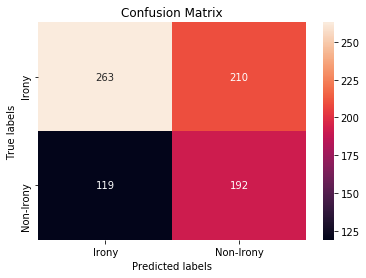

In [56]:
def plotCM(cm):
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt="d"); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['Irony', 'Non-Irony']); ax.yaxis.set_ticklabels(['Irony', 'Non-Irony']);

svm_cm = confusion_matrix(y_test, y_pred)
plotCM(svm_cm)